In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-03-13 01:11:26.274191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741821086.284705 4121596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741821086.288011 4121596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 01:11:26.300093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

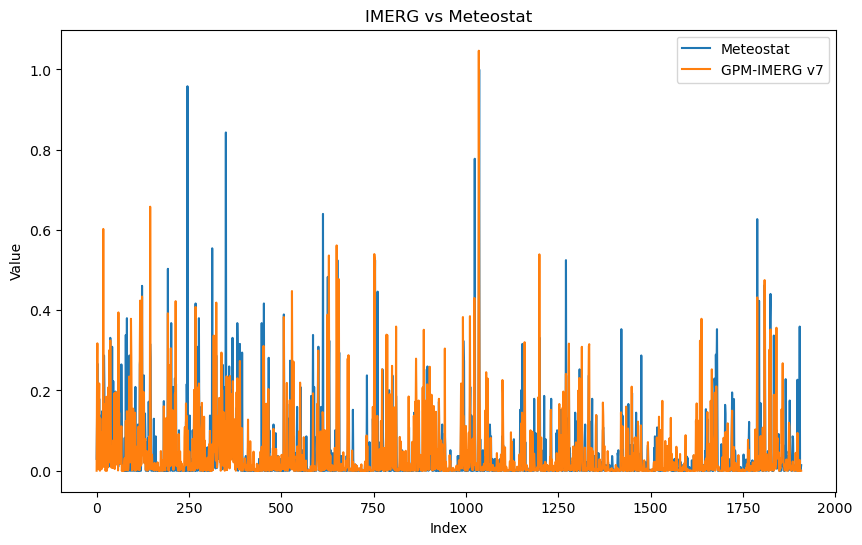

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
batch_size = 4
epochs = 1000
window_size = 4

In [5]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=False)
test_set = windowed_dataset(test, window_size, batch_size, shuffle=False)

I0000 00:00:1741821087.948550 4121596 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21986 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


2025-03-13 01:11:28.149065: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(7624,)
(1909,)


/tmp/ipykernel_4121596/2603999581.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


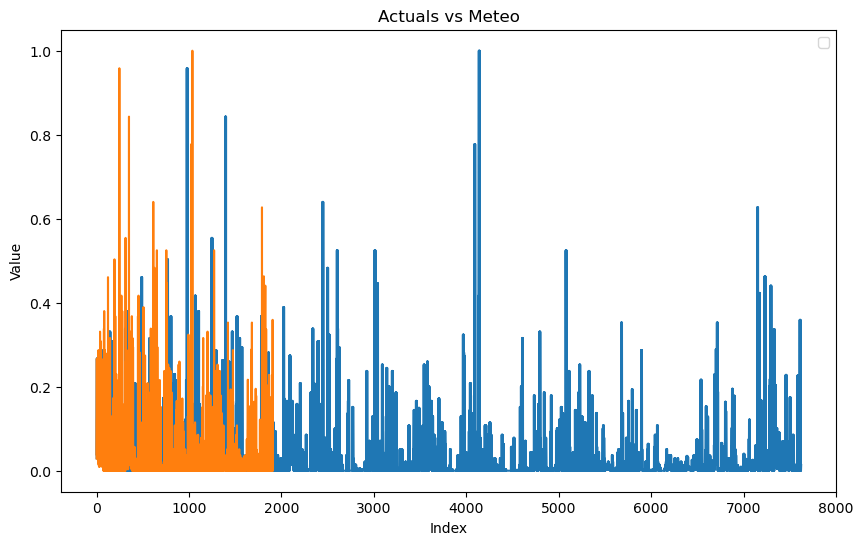

In [8]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
def build_model(lr=7.77e-5):
    model = keras.Sequential([
        layers.Input(shape=(window_size, 1)),
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        # Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        # MaxPooling1D(pool_size=2),
        # Conv1DTranspose(filters=128, kernel_size=3, padding='same', activation='relu'),
        # UpSampling1D(size=2),
        Conv1DTranspose(filters=64, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=32, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=1, kernel_size=3, padding='same', activation='relu')
    ])

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=3000,
        decay_rate=0.9,
        staircase=True
    )

    model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss='mse', metrics=['mae'])
    return model

In [10]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1, 64)          │        12,352 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2, 32)          │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 4, 1)           │            97 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')]
)

Epoch 1/1000


I0000 00:00:1741821089.386355 4121862 service.cc:148] XLA service 0x7f9f9c0031f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741821089.386371 4121862 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-13 01:11:29.410209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741821089.506106 4121862 cuda_dnn.cc:529] Loaded cuDNN version 90300


    172/Unknown 2s 886us/step - loss: 0.0140 - mae: 0.0750

I0000 00:00:1741821090.179506 4121862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    429/Unknown 3s 3ms/step - loss: 0.0113 - mae: 0.0644

2025-03-13 01:11:31.293269: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:31.293295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:31.293306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0113 - mae: 0.0643 - val_loss: 0.0075 - val_mae: 0.0421
Epoch 2/1000
173/429 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.0092 - mae: 0.0644

2025-03-13 01:11:31.589670: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:31.589697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:31.589710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0082 - mae: 0.0568 - val_loss: 0.0070 - val_mae: 0.0413
Epoch 3/1000
115/429 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0086 - mae: 0.0636

2025-03-13 01:11:31.986075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:32.029282: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:32.029300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:32.029310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - mae: 0.0548 - val_loss: 0.0067 - val_mae: 0.0404
Epoch 4/1000
111/429 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0084 - mae: 0.0626

2025-03-13 01:11:32.427158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:32.427177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:32.470513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:32.470534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0076 - mae: 0.0537 - val_loss: 0.0065 - val_mae: 0.0394
Epoch 5/1000
115/429 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.0083 - mae: 0.0616

2025-03-13 01:11:32.864446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:32.864467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:32.907324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:32.907340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:32.907349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0074 - mae: 0.0527 - val_loss: 0.0064 - val_mae: 0.0390
Epoch 6/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0083 - mae: 0.0610

2025-03-13 01:11:33.299352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:33.299375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:33.341279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:33.341297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0073 - mae: 0.0521 - val_loss: 0.0063 - val_mae: 0.0385
Epoch 7/1000
119/429 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0083 - mae: 0.0605

2025-03-13 01:11:33.728309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:33.728330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:33.769981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:33.769999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0073 - mae: 0.0517 - val_loss: 0.0063 - val_mae: 0.0383
Epoch 8/1000
116/429 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0083 - mae: 0.0600

2025-03-13 01:11:34.157027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:34.199070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:34.199090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.0072 - mae: 0.0513 - val_loss: 0.0062 - val_mae: 0.0381
Epoch 9/1000
171/429 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0083 - mae: 0.0584

2025-03-13 01:11:34.631503: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:34.631528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:34.631541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0072 - mae: 0.0510 - val_loss: 0.0062 - val_mae: 0.0380
Epoch 10/1000
115/429 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.0082 - mae: 0.0594

2025-03-13 01:11:35.026396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:35.026416: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:35.068922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:35.068942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0071 - mae: 0.0508 - val_loss: 0.0062 - val_mae: 0.0378
Epoch 11/1000
170/429 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0082 - mae: 0.0579

2025-03-13 01:11:35.506720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:35.506741: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0071 - mae: 0.0506 - val_loss: 0.0062 - val_mae: 0.0376
Epoch 12/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0081 - mae: 0.0589

2025-03-13 01:11:35.898846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:35.898869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:35.941423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:35.941439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0071 - mae: 0.0504 - val_loss: 0.0062 - val_mae: 0.0376
Epoch 13/1000
113/429 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0081 - mae: 0.0588

2025-03-13 01:11:36.336428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:36.379082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:36.379099: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0503 - val_loss: 0.0062 - val_mae: 0.0375
Epoch 14/1000
113/429 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0080 - mae: 0.0586

2025-03-13 01:11:36.774931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:36.817389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:36.817406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0070 - mae: 0.0502 - val_loss: 0.0062 - val_mae: 0.0374
Epoch 15/1000
171/429 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0081 - mae: 0.0571

2025-03-13 01:11:37.256680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:37.256699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0070 - mae: 0.0500 - val_loss: 0.0062 - val_mae: 0.0374
Epoch 16/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0080 - mae: 0.0582

2025-03-13 01:11:37.646495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:37.646514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:37.687799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:37.687816: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0070 - mae: 0.0499 - val_loss: 0.0062 - val_mae: 0.0373
Epoch 17/1000
115/429 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0080 - mae: 0.0581

2025-03-13 01:11:38.074670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.074690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:38.115609: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:38.115625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.115638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0070 - mae: 0.0499 - val_loss: 0.0062 - val_mae: 0.0373
Epoch 18/1000
117/429 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0080 - mae: 0.0580

2025-03-13 01:11:38.506576: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.506595: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:38.549552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.549574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0070 - mae: 0.0498 - val_loss: 0.0062 - val_mae: 0.0372
Epoch 19/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0080 - mae: 0.0579

2025-03-13 01:11:38.937177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.937195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:38.979478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:38.979495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0070 - mae: 0.0497 - val_loss: 0.0062 - val_mae: 0.0372
Epoch 20/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0080 - mae: 0.0579

2025-03-13 01:11:39.374723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:39.374742: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:39.418343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:39.418360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.0070 - mae: 0.0497 - val_loss: 0.0062 - val_mae: 0.0372
Epoch 21/1000
113/429 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0080 - mae: 0.0578

2025-03-13 01:11:39.811785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:39.811805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:39.854878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:39.854896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mae: 0.0496 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 22/1000
111/429 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0080 - mae: 0.0577

2025-03-13 01:11:40.252540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:40.252560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:40.294240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:40.294258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.0070 - mae: 0.0495 - val_loss: 0.0062 - val_mae: 0.0372
Epoch 23/1000
170/429 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0081 - mae: 0.0563

2025-03-13 01:11:40.731714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:40.731733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mae: 0.0495 - val_loss: 0.0062 - val_mae: 0.0372
Epoch 24/1000
117/429 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0080 - mae: 0.0575

2025-03-13 01:11:41.129473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:41.172007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:41.172024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.0070 - mae: 0.0495 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 25/1000
107/429 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0079 - mae: 0.0576

2025-03-13 01:11:41.561316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:41.601727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:41.601751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mae: 0.0494 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 26/1000
114/429 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0080 - mae: 0.0575

2025-03-13 01:11:42.006966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:42.006990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:42.049229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:42.049248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.0069 - mae: 0.0494 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 27/1000
113/429 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0079 - mae: 0.0575

2025-03-13 01:11:42.443283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:42.443305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:42.485248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:42.485270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0069 - mae: 0.0494 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 28/1000
110/429 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0079 - mae: 0.0574

2025-03-13 01:11:42.873435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:42.916522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:42.916537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0493 - val_loss: 0.0062 - val_mae: 0.0370
Epoch 29/1000
175/429 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0080 - mae: 0.0558

2025-03-13 01:11:43.366803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:43.366823: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0069 - mae: 0.0493 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 30/1000
117/429 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0080 - mae: 0.0571

2025-03-13 01:11:43.748777: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:43.790833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:43.790850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.0069 - mae: 0.0492 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 31/1000
113/429 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0079 - mae: 0.0571

2025-03-13 01:11:44.177186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:44.177205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:44.225472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:44.225491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0492 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 32/1000
111/429 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0079 - mae: 0.0572

2025-03-13 01:11:44.623061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:44.665171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:44.665192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0491 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 33/1000
112/429 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0079 - mae: 0.0571

2025-03-13 01:11:45.062955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.062975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:45.105390: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-13 01:11:45.105410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.105421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0491 - val_loss: 0.0062 - val_mae: 0.0371
Epoch 34/1000
116/429 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0079 - mae: 0.0570

2025-03-13 01:11:45.502453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.502475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:45.545135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.545150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0069 - mae: 0.0491 - val_loss: 0.0062 - val_mae: 0.0370
Epoch 35/1000
115/429 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0079 - mae: 0.0570

2025-03-13 01:11:45.937209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.937228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:45.979789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:45.979805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0069 - mae: 0.0490 - val_loss: 0.0062 - val_mae: 0.0370


2025-03-13 01:11:46.371282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:46.371301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744
2025-03-13 01:11:46.413202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13106692899891626523
2025-03-13 01:11:46.413220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15088626199464042744


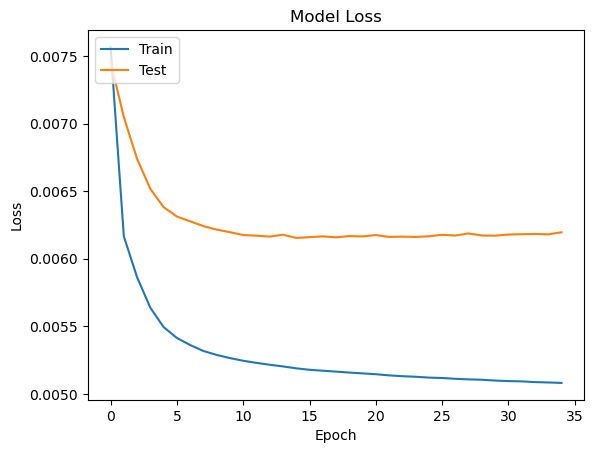

In [12]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
(188, 4, 1)
(188, 4, 1)


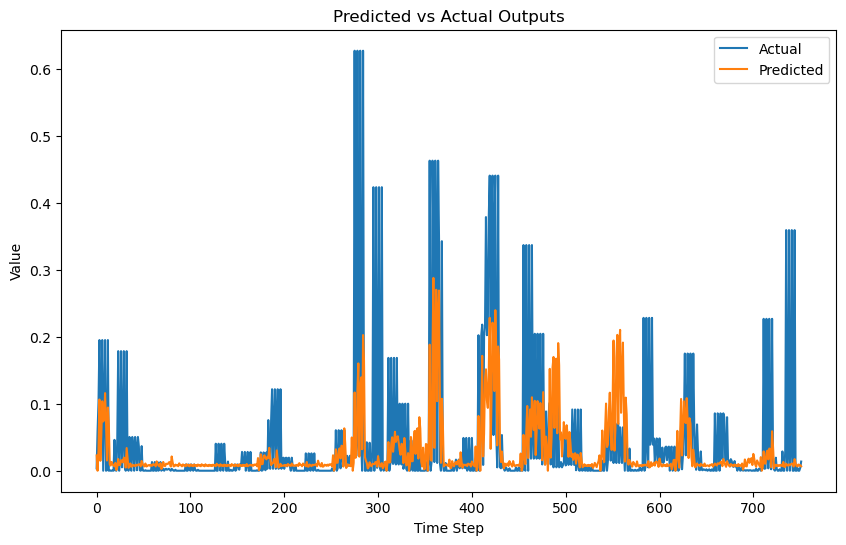

In [13]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
model.save_weights('corrector-ae.weights.h5')

In [15]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-daily-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step
8764
8766


/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
